In [1]:
import os
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm

c:\Users\user\Miniconda3\envs\deepvit\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


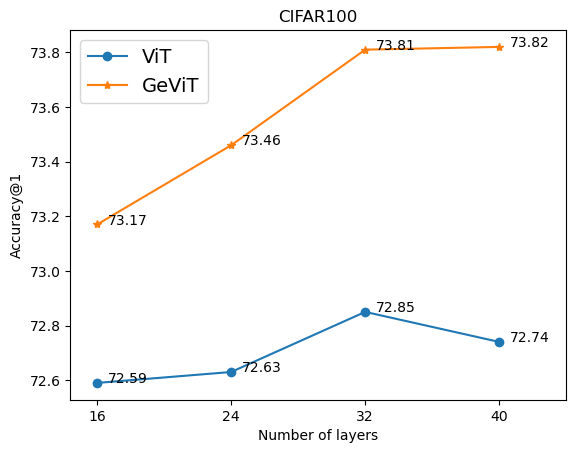

In [2]:
x = [1, 2, 3, 4]
vit = [72.590, 72.630, 72.850, 72.740]
gevit = [73.170, 73.460, 73.810, 73.820]

plt.xticks(x, ['16', '24', '32', '40'])

for x_c, y_c in zip(x, vit):
    plt.annotate(y_c, xy=(x_c + 0.08, y_c))

for x_c, y_c in zip(x, gevit):
    plt.annotate(y_c, xy=(x_c + 0.08, y_c))

plt.xlim(0.8, 4.5)
plt.title('CIFAR100')
plt.plot(x, vit, marker='o', label='ViT')
plt.plot(x, gevit, marker='*', label='GeViT')
plt.xlabel('Number of layers')
plt.ylabel('Accuracy@1')
plt.legend(fontsize=14)
plt.show()

In [3]:
def _get_cache_path(dataset_name: str, mode: str, data_path):
    import hashlib

    seed = dataset_name + mode

    h = hashlib.sha1(seed.encode()).hexdigest()
    cache_path = os.path.join(data_path, f"{mode}_{h[:10]}.pt")
    cache_path = os.path.expanduser(cache_path)
    return cache_path

dataset_name = 'cifar'  # 'cifar', 'imagenet'
dataset_path = './dataset' # './dataset/CIFAR100', './dataset/ImageNet'

cache_path = _get_cache_path(dataset_name, 'train', dataset_path)
cache_path_test = _get_cache_path(dataset_name, 'val', dataset_path)

In [4]:
dataset = torch.load(cache_path)
dataset_test = torch.load(cache_path_test)

train_sampler = torch.utils.data.RandomSampler(dataset)
test_sampler = torch.utils.data.SequentialSampler(dataset_test)

data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, sampler=train_sampler)
data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, sampler=test_sampler)

In [5]:
device = 'cuda'

In [6]:
from box import Box

args = {
    'train_crop_size': 224,
    'patches_size': (16, 16),
    'hidden_size': 384,
    'transformer': {
        'mlp_dim': 384 * 3,
        'num_heads': 12,
        'num_layers': 40,
        'attention_dropout': 0,
        'dropout': 0.2,
    },
    'classifier': 'token',
    'alpha': 0.1,
    'beta': 0.5,
    'representation_size': None,
}

args = Box(args)

In [7]:
from models.GeViT import GeViT
from models.ViT import ViT
num_classes = len(dataset.classes)

model_name = f"ViT-B_{args.transformer.num_layers}"

gevit = GeViT(args, num_classes=num_classes)
vit = ViT(args, num_classes=num_classes)

checkout_path_gevit = f'./gevit_{args.transformer.num_layers}/model_.pth'
checkout_path_vit = f'./vit_{args.transformer.num_layers}/model_.pth'

checkout_gevit = torch.load(checkout_path_gevit)
checkout_vit = torch.load(checkout_path_vit)

In [8]:
vit.load_state_dict(checkout_vit['model'])
gevit.load_state_dict(checkout_gevit['model'])

<All keys matched successfully>

In [9]:
loader = iter(data_loader_test)

In [10]:
def conver_to_numpy(x_list):
    ret_list = []
    for x in x_list:
        ret_list.append(x.squeeze().detach().cpu().numpy())
    return np.array(ret_list)


def save_result(model, img, feature_list, attention_list):
    _, _, fe, attn = model(img)
    feature_list.append(conver_to_numpy(fe))
    attention_list.append(conver_to_numpy(attn))

In [11]:
fe_list_gevit = []
attn_list_gevit = []

fe_list_vit = []
attn_list_vit = []

data_num = 100

for _ in tqdm(range(data_num)):
    img, label = next(loader)
    save_result(gevit, img, fe_list_gevit, attn_list_gevit)
    save_result(vit, img, fe_list_vit, attn_list_vit)

100%|██████████| 100/100 [00:54<00:00,  1.82it/s]


In [12]:
fe_list_gevit = np.array(fe_list_gevit)
attn_list_gevit = np.array(attn_list_gevit)

fe_list_vit = np.array(fe_list_vit)
attn_list_vit = np.array(attn_list_vit)

In [13]:
def cos_sim_feature(fe, last=None):
    if last is None: output = cosine_similarity(fe)
    else: output = cosine_similarity(fe, last)

    n = output.shape[0]
    sim = 0
    for i in range(n):
        for j in range(i+1, n):
            sim += abs(output[i][j])
    
    ret = sim * 2 / (n - 1) / (n)
    
    return ret

In [14]:
def mean_sim(fe_lists):
    sim_list_all = []
    for fe_list in tqdm(fe_lists):
        sim_list = []
        for fe in fe_list: 
            sim_list.append(cos_sim_feature(fe))
        sim_list_all.append(sim_list)
    
    sim_list_all = np.array(sim_list_all)
    return sim_list_all.mean(axis=0)

In [15]:
mean_sim_gevit = mean_sim(fe_list_gevit)
mean_sim_vit = mean_sim(fe_list_vit)

100%|██████████| 100/100 [00:28<00:00,  3.53it/s]


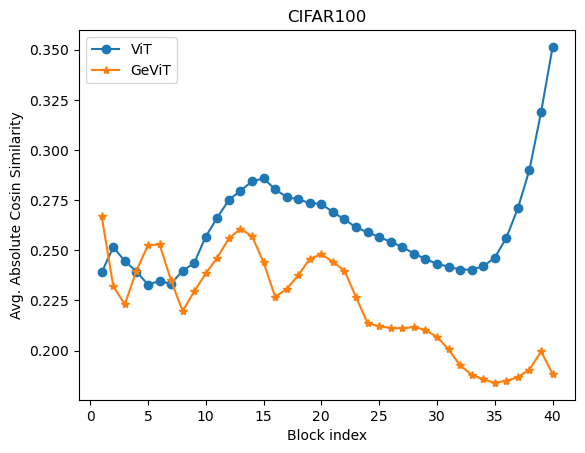

In [16]:
x = list(range(1, args.transformer.num_layers+1))
plt.plot(x, mean_sim_vit, label='ViT', marker='o')
plt.plot(x, mean_sim_gevit, label='GeViT', marker='*')
plt.title('CIFAR100')
plt.xlabel('Block index')
plt.ylabel('Avg. Absolute Cosin Similarity')
plt.legend()

In [17]:
mean_attn_list_gevit = attn_list_gevit.mean(axis=0).mean(axis=1)
mean_attn_list_vit = attn_list_vit.mean(axis=0).mean(axis=1)

In [18]:
def vis_attn(layer, attn_map, prob):
    data_np = attn_map[layer]
    seed = (data_np.max() - data_np.min())
    sns.heatmap(data_np, cmap='Blues', vmin=data_np.min(), vmax=data_np.max() - (seed * prob), cbar=False)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [40]:
layer_index = 7
prob = 0.3

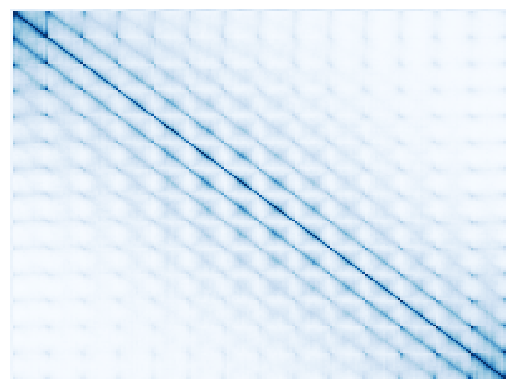

In [45]:
vis_attn(layer_index, mean_attn_list_vit, prob=0.5)

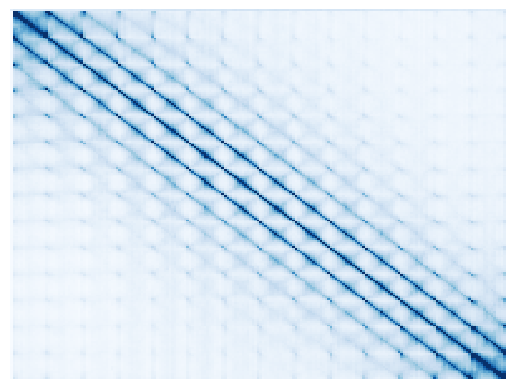

In [46]:
vis_attn(layer_index, mean_attn_list_gevit, prob=0.7)

In [22]:
layer_index = 15

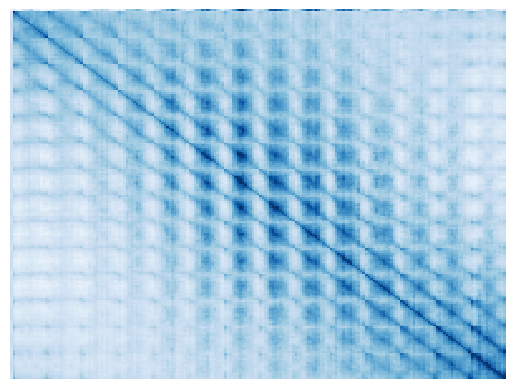

In [23]:
vis_attn(layer_index, mean_attn_list_vit, prob)

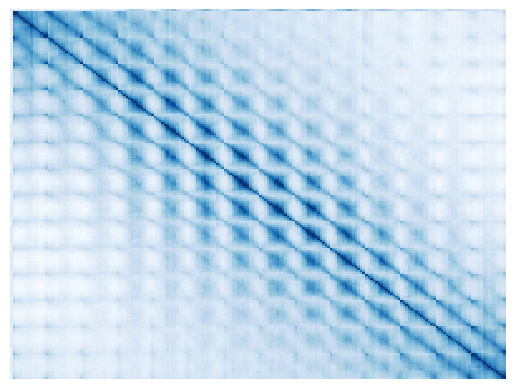

In [24]:
vis_attn(layer_index, mean_attn_list_gevit, prob)

In [25]:
layer_index = 23

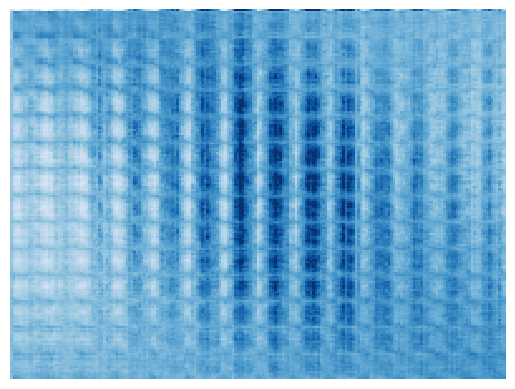

In [26]:
vis_attn(layer_index, mean_attn_list_vit, prob)

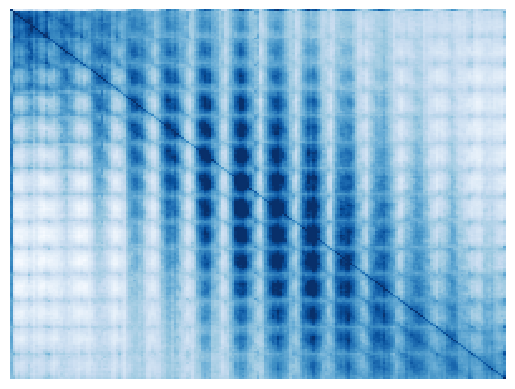

In [27]:
vis_attn(layer_index, mean_attn_list_gevit, prob)

In [47]:
layer_index = 31

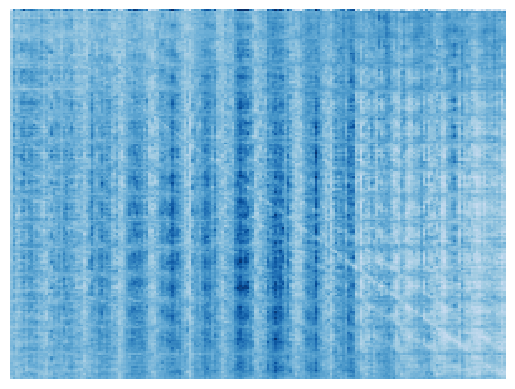

In [50]:
vis_attn(layer_index, mean_attn_list_vit, prob=0.1)

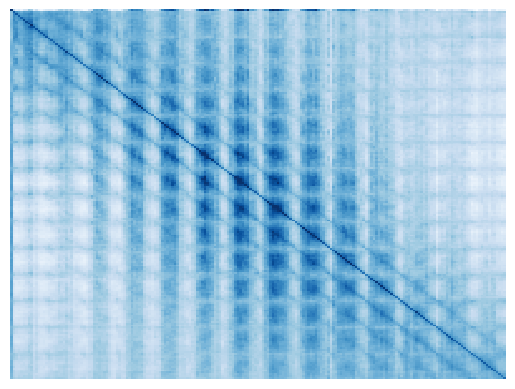

In [30]:
vis_attn(layer_index, mean_attn_list_gevit, prob)

In [53]:
layer_index = 39

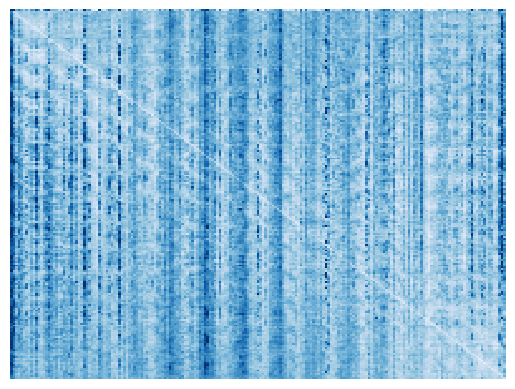

In [55]:
vis_attn(layer_index, mean_attn_list_vit, prob=0.3)

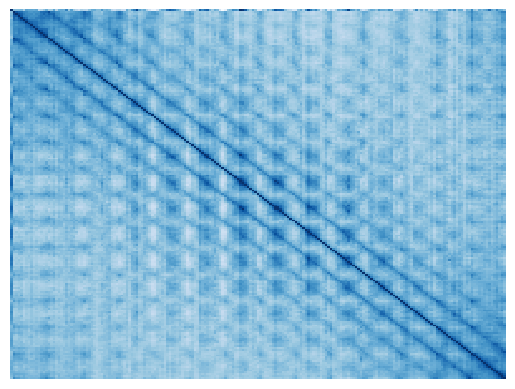

In [36]:
vis_attn(layer_index, mean_attn_list_gevit, prob=0.5)